In [17]:
import sys
import os
import numpy as np
import pandas as pd
#import shap
import matplotlib.pyplot as plt
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Weave'))
from Weave.utils import collapse_restore_multiindex
from Weave.models import HybridExceedenceModel, fit_predict
from Weave.inspection import ImportanceData, scatterplot, data_for_shapplot

In [5]:
shap.initjs()

NameError: name 'shap' is not defined

In [20]:
#basepath = Path('/nobackup_1/users/straaten')
basepath = Path('/scistor/ivm/jsn295/')
#inputpath = basepath / 'shaptest'
inputpath = basepath / 'clusters_cv_spearmanpar_varalpha_strict'
shaps = ImportanceData(basepath = basepath / 'shap_standard_val_q0666', respagg = [31,11], separation = [-15,-11], quantile = 0.666, model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = True, n_jobs = 15))
shaps.load_data(X_too = True, y_too = True, inputpath = inputpath)

In [6]:
shaps.model

Hybrid combination with RandomForestRegressor(n_jobs=15) on top of LogisticRegression with scaled time index as only input: penalty=l2, C=1.0, fit_intercept=True

In [117]:
test = data_for_shapplot(shaps, shaps.df.iloc[:,-100:].dropna(axis = 0, how = 'any'))

In [119]:
shap.force_plot(**test)

In [21]:
# 2015 heatwave = 3128:
# 2019 heatwave = -92:
residuals = shaps.df.iloc[:,:].dropna(axis = 0, how = 'all').groupby(['respagg','separation']).apply(lambda df: df.sum(axis = 0)).T
baserate = shaps.get_baserate(when = residuals.index) # Not separation dependent
total = pd.DataFrame(residuals.values + baserate.loc[:,residuals.columns.get_level_values('respagg')].values, columns = residuals.columns, index = residuals.index)
binaries = shaps.get_exceedences(when = residuals.index)
# These y plots actually need dots on the lines, whether it was a true or a false.
# It almost looks as if the respagg of 11 has a stronger seasonality. I.e. the drop from june to july/august.

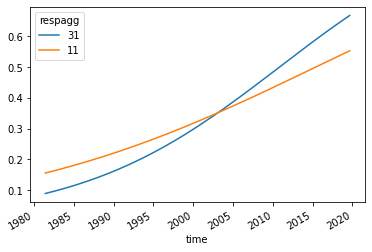

In [22]:
baserate.plot()

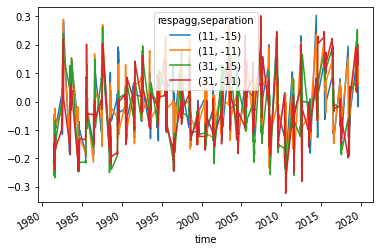

In [15]:
residuals.plot() #baserate.plot()

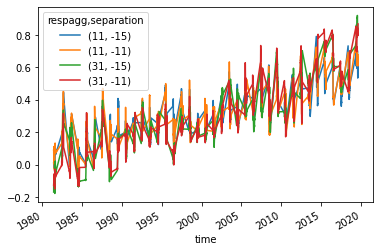

In [16]:
total.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aac075539e8>,
      dtype=object)

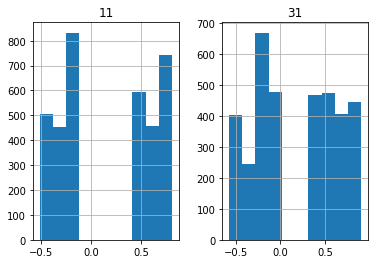

In [18]:
((binaries + 0.0) - baserate).hist()

In [24]:
np.stack([1-baserate[31]/baserate[31],baserate[31]], axis = -1) # Negative, positive

array([[0.91716384, 0.08283616],
       [0.91714675, 0.08285325],
       [0.91712967, 0.08287033],
       ...,
       [0.41097221, 0.58902779],
       [0.41092948, 0.58907052],
       [0.41088675, 0.58911325]])

In [38]:
truevals = binaries[31]* (np.log((1-baserate[31])/baserate[31])) # occurrences times oddsratio against true 

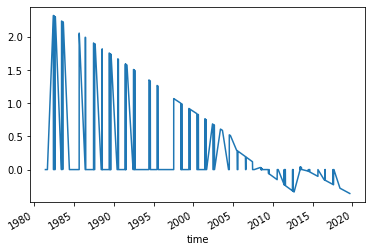

In [39]:
truevals.plot()

In [40]:
negvals = (~binaries[31])* np.log((baserate[31]/(1-baserate[31]))) # non-occurrences times oddsratio against False 

In [26]:
negvals.plot()

NameError: name 'negvals' is not defined

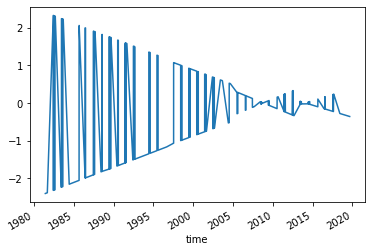

In [42]:
(negvals + truevals).plot()

In [23]:
posloss = (-np.log(baserate[31])) * binaries[31]
negloss = (-np.log(1-baserate[31]))  * (~binaries[31])

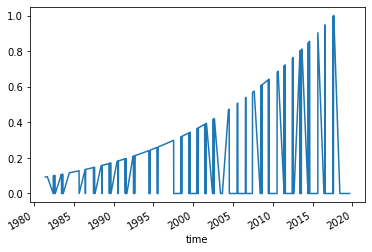

In [25]:
negloss.plot()

Text(0.5, 1.0, 'Based on logistic regression loss this is more of a multiplier')

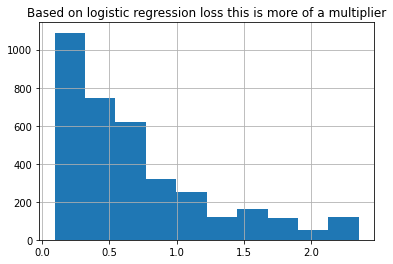

In [24]:
(negloss + posloss).hist()
plt.title('Based on logistic regression loss this is more of a multiplier') # Not too many extreme values.

In [34]:
(negloss + posloss).mean()

0.6843604638028398

In [39]:
logloss = -np.log(baserate[31]) * binaries[31] - np.log(1 - baserate[31])  * (~binaries[31])

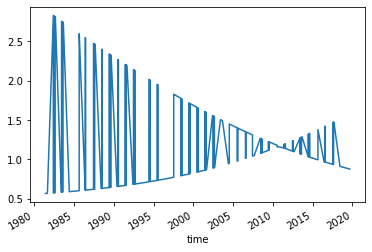

In [43]:
(logloss - logloss.quantile(0.5) + 1).plot()

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 30, max_features = 35, n_estimators=1500, n_jobs=20)
test = fit_predict(rf, X_in = shaps.X.T, y_in = (negloss + posloss), n_folds = 5)

In [31]:
test.index = test.index.droplevel('fold')

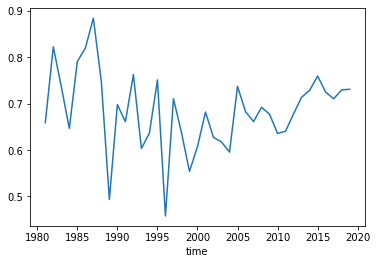

In [33]:
test.groupby(test.index.year).mean().plot()

In [123]:
test2 = data_for_shapplot(shaps, shaps.df.loc[(slice(None),4),:].dropna(axis = 1, how = 'all'), fit_base=True) # Cannot do this across folds

Fitting of base value not yet implemented. Needs transformed y data


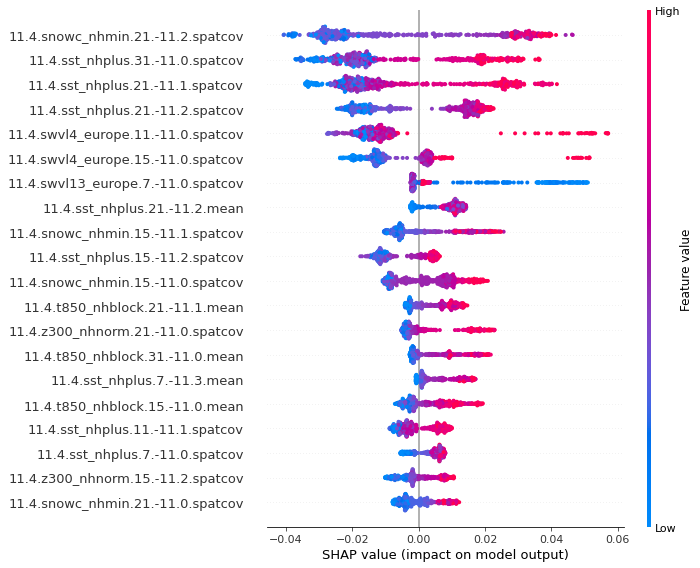

In [124]:
shap.summary_plot(**test2)

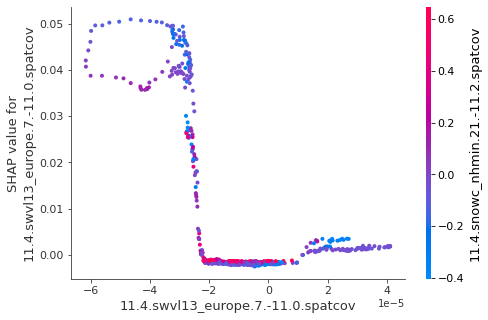

In [127]:
colvar =  '11.4.snowc_nhmin.21.-11.2.spatcov' #'3.4.snowc_nhmin.11.-3.1.spatcov' #'3.4.z300_nhnorm.5.-3.0.spatcov'
xvar = '11.4.swvl13_europe.7.-11.0.spatcov' #'3.4.sst_nhplus.31.-3.2.spatcov' #'3.4.z300_nhnorm.5.-3.0.spatcov' #'3.4.swvl4_europe.15.-3.0.spatcov' #'3.4.swvl4_europe.7.-3.0.spatcov'
shap.dependence_plot(ind = xvar, interaction_index= colvar, **test2)

Difficult to find things in the dependency plots. Some noteworthy things
* Last fold swvl4 seems less out of balance than with the previous approach.
* '3.4.snowc_nhmin.11.-3.1.spatcov' might modulate the most dominant sst a bit '3.4.sst_nhplus.31.-3.2.spatcov' short before the event. 
* Negative values of 11.4.sst_nhplus.31.15.1.spatcov seem to prohibit the utmost positive probabilistic response to 11.4.t850_nhblock.21.-15.0.mean. In fold 3 this also shows as a moderation effect (11.3.sst_nhplus.21.-15.1.spatcov on 11.3.t850_nhblock.21.-15.0.mean

Z300 influence on the thing is heightened (steeper slope) when the background sst conditions are suitable (red values), then the circulation pattern becomes decisive on whether probability is heightened or lowered.

Try to see shap differences over the folds.

In [18]:
shap_per_year = df.groupby(df.index.get_level_values('time').year).mean()
val_per_year = df_in.groupby(df_in.index.year).mean()

In [50]:
shap.force_plot(base_value = 0.2, shap_values=shap_per_year.values, features=val_per_year.values, feature_names=df.columns, ordering_keys=val_per_year.index)

<AxesSubplot:title={'center':'swvl4_europe.15.0 at -21 days'}, xlabel='time'>

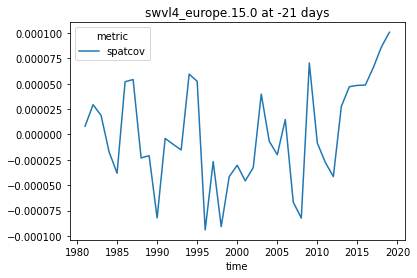

In [25]:
val_per_year[('swvl4_europe',15,-36,-21,0)].plot(title = 'swvl4_europe.15.0 at -21 days')
#val_per_year[('swvl4_europe',11,-32,-21,0)].plot()

<AxesSubplot:xlabel='time'>

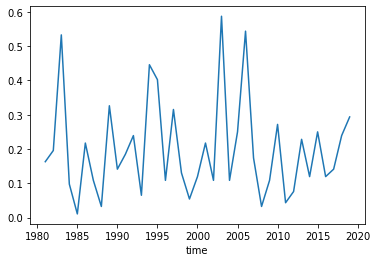

In [20]:
y.groupby(y.index.year).mean().plot()

In [47]:
hw_slice = slice(2024,2116)
hw_slice = 2024
shap.force_plot(base_value = 0.2, shap_values=df.values[hw_slice,:], features=df_in.values[hw_slice,], feature_names=df.columns)

### Make a plot for the last slice. 2013 till 2019. To see if train and test shaps differ.

In [42]:
testpath = '/nobackup_1/users/straaten/shaptest_standard/7/-21/responsagg_separation.parquet'
trainpath = '/nobackup_1/users/straaten/shaptest_standard_train/7/-21/responsagg_separation.parquet'
inputpath = '/nobackup_1/users/straaten/spatcov/precursor.multiagg.parquet'
df_test = pd.read_parquet(testpath).drop('expected_value', axis = 1).sort_index(axis = 1)
df_train = pd.read_parquet(trainpath).drop('expected_value', axis = 1).sort_index(axis = 1)
df_in = pd.read_parquet(inputpath).loc[df_test.index.get_level_values('time'), (slice(None),slice(None),slice(None),-21,slice(None),'spatcov')].sort_index(axis = 1)

dropping on a non-lexsorted multi-index without a level parameter may impact performance.


In [43]:
df_in

variable   siconc_nhmin                                                    \
timeagg              11                  15                  21             
lag                 -32                 -36                 -42             
separation          -21                 -21                 -21             
clustid               0         1         0         1         0         1   
metric          spatcov   spatcov   spatcov   spatcov   spatcov   spatcov   
time                                                                        
1981-06-01    -0.000572 -0.009737 -0.000858 -0.009225 -0.000141 -0.008526   
1981-06-02    -0.000451 -0.009344 -0.000805 -0.008957 -0.000159 -0.008423   
1981-06-03    -0.000376 -0.008948 -0.000746 -0.008643 -0.000169 -0.008326   
1981-06-04    -0.000180 -0.008501 -0.000639 -0.008284 -0.000183 -0.008190   
1981-06-05     0.000187 -0.008059 -0.000489 -0.007868 -0.000191 -0.008040   
...                 ...       ...       ...       ...       ...       ...   
2019-08-27    -0.006994 -0.005790 -0.001246 -0.008504 -0.001368 -0.015975   
2019-08-28    -0.006855 -0.005662 -0.001215 -0.008177 -0.001387 -0.015568   
2019-08-29    -0.006709 -0.005521 -0.001177 -0.007876 -0.001361 -0.015135   
2019-08-30    -0.006564 -0.005343 -0.001141 -0.007565 -0.001322 -0.014708   
2019-08-31    -0.006410 -0.005123 -0.001102 -0.007270 -0.001281 -0.014385   

variable                                 snowc_nhmin  ... transp_europe  \
timeagg           31                              3   ...            31   
lag              -52                             -24  ...           -52   
separation       -21                             -21  ...           -21   
clustid            0         1         2           0  ...             0   
metric       spatcov   spatcov   spatcov     spatcov  ...       spatcov   
time                                                  ...                 
1981-06-01  0.000246  0.001823 -0.001804    0.010737  ...  2.985431e-06   
1981-06-02  0.000253  0.001940 -0.001820    0.013695  ...  2.453708e-06   
1981-06-03  0.000261  0.002071 -0.001843    0.017514  ...  4.410213e-06   
1981-06-04  0.000271  0.002214 -0.001867    0.016045  ...  5.992192e-06   
1981-06-05  0.000279  0.002362 -0.001890    0.013555  ...  6.381308e-06   
...              ...       ...       ...         ...  ...           ...   
2019-08-27  0.002389 -0.007148  0.000238   -0.007237  ... -2.481443e-07   
2019-08-28  0.002397 -0.006598  0.000241   -0.008200  ... -6.359123e-07   
2019-08-29  0.002397 -0.006106  0.000243   -0.007987  ... -2.418079e-06   
2019-08-30  0.002393 -0.005743  0.000242   -0.007707  ... -3.414632e-06   
2019-08-31  0.002379 -0.005358  0.000244   -0.002767  ... -4.987931e-06   

variable                 z300_nhnorm                                           \
timeagg                           1         3         5         7          11   
lag                              -22       -24       -26       -28        -32   
separation                       -21       -21       -21       -21        -21   
clustid                1           0         0         0         0          0   
metric           spatcov     spatcov   spatcov   spatcov   spatcov    spatcov   
time                                                                            
1981-06-01  1.974174e-06   49.664886 -3.640584 -3.482409 -7.931938 -10.195770   
1981-06-02  2.032710e-06   66.057800 -1.847057 -3.470687 -7.909668  -9.474339   
1981-06-03  2.079100e-06   68.934563 -0.529348 -1.381757 -6.669040  -8.151914   
1981-06-04  2.110881e-06   50.757591  0.937225  2.185338 -4.061729 -10.526679   
1981-06-05  2.108661e-06   14.749125  2.935915  1.808133 -2.783260 -18.297203   
...                  ...         ...       ...       ...       ...        ...   
2019-08-27  1.480388e-06  -52.090950  0.776420  3.627255  8.243290 -57.172405   
2019-08-28  1.588692e-06  -37.904881  0.946684  2.583883  6.480862 -56.940704   
2019-08-29  1.285203e-06  -61.467098  0.933403 

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


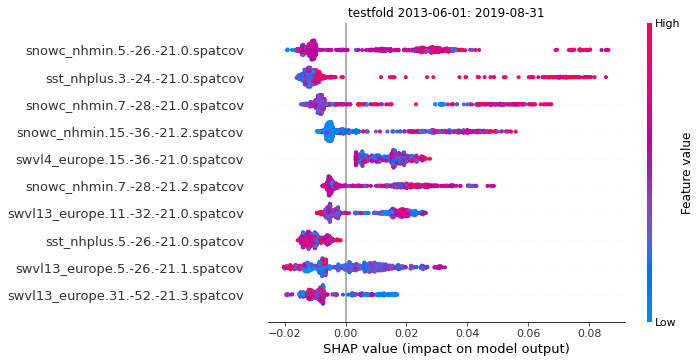

In [48]:
testfold = 4
tmin = df_test.loc[(testfold,)].index.min().strftime('%Y-%m-%d')
tmax = df_test.loc[(testfold,)].index.max().strftime('%Y-%m-%d')
testdata = df_test.loc[(testfold,),:].sort_index(axis = 1)
collapse_restore_multiindex(testdata,axis = 1, inplace = True)
plt.title(f'testfold {tmin}: {tmax}')
shap.summary_plot(shap_values=testdata.values, features= df_in.loc[testdata.index.get_level_values('time'),:].values, feature_names=testdata.columns, max_display = 10)


In [53]:
df_test.loc[(testfold,),:].

indexing past lexsort depth may impact performance.


variable   siconc_nhmin                                                    \
timeagg              11                  15                  21             
lag                 -32                 -36                 -42             
separation          -21                 -21                 -21             
clustid               0         1         0         1         0         1   
metric          spatcov   spatcov   spatcov   spatcov   spatcov   spatcov   
time                                                                        
2013-06-01    -0.001976  0.000244  0.002834 -0.000535 -0.002845  0.000267   
2013-06-02    -0.001817  0.000101  0.003085 -0.000529 -0.002840  0.000125   
2013-06-03    -0.001063 -0.000025  0.002597 -0.000253 -0.002716  0.000069   
2013-06-04    -0.001351 -0.000075  0.002123 -0.000238 -0.002707  0.000094   
2013-06-05    -0.000658 -0.000221  0.000750 -0.000323 -0.002653  0.000120   
...                 ...       ...       ...       ...       ...       ...   
2019-08-27    -0.002923 -0.000344 -0.001590 -0.000171 -0.004082  0.002737   
2019-08-28    -0.002910 -0.000254 -0.001476 -0.000458 -0.004044  0.002594   
2019-08-29    -0.002974 -0.000275 -0.001415 -0.000464 -0.004020  0.002726   
2019-08-30    -0.002832 -0.000322 -0.001399 -0.000472 -0.004040  0.002681   
2019-08-31    -0.002827 -0.000282 -0.001414 -0.000490 -0.004003  0.002620   

variable                                 snowc_nhmin  ... transp_europe  \
timeagg           31                              11  ...            31   
lag              -52                             -32  ...           -52   
separation       -21                             -21  ...           -21   
clustid            0         1         2           0  ...             0   
metric       spatcov   spatcov   spatcov     spatcov  ...       spatcov   
time                                                  ...                 
2013-06-01 -0.000159 -0.001267  0.000519   -0.002313  ...     -0.001397   
2013-06-02 -0.000249 -0.001071  0.000615   -0.002206  ...     -0.001262   
2013-06-03 -0.000333 -0.000771  0.001057   -0.002259  ...     -0.001082   
2013-06-04 -0.000383 -0.000638  0.001159   -0.002224  ...     -0.001034   
2013-06-05 -0.000423 -0.000506  0.001146   -0.002578  ...     -0.000800   
...              ...       ...       ...         ...  ...           ...   
2019-08-27  0.006383 -0.000048  0.000274   -0.003349  ...      0.000097   
2019-08-28  0.006500 -0.000249  0.000316   -0.003342  ...      0.000100   
2019-08-29  0.006397 -0.000227  0.000344   -0.003480  ...      0.000101   
2019-08-30  0.006571 -0.000246  0.000355   -0.003508  ...      0.000075   
2019-08-31  0.006272 -0.000244  0.000355   -0.003503  ...      0.000077   

variable             z300_nhnorm                                          \
timeagg                        1        11        15        21         3   
lag                          -22       -32       -36       -42       -24   
separation                   -21       -21       -21       -21       -21   
clustid            1           0         0         0         0         0   
metric       spatcov     spatcov   spatcov   spatcov   spatcov   spatcov   
time                                                                       
2013-06-01 -0.000111    0.001384 -0.003884  0.009577 -0.000255 -0.000156   
2013-06-02 -0.000126    0.002568 -0.003904  0.007954 -0.000134 -0.000134   
2013-06-03 -0.000100    0.002448 -0.003482  0.007844 -0.000173  0.000210   
2013-06-04 -0.000096    0.001237 -0.003474  0.006395 -0.000186  0.000029   
2013-06-05 -0.000102   -0.000902 -0.003502  0.001424 -0.000227 -0.000161   
...              ...         ...       ...       ...       ...       ...   
2019-08-27  0.000153   -0.001352 -0.005548 -0.002998 -0.000383 -0.000261   
2019-08-28  0.000143   -0.001299 -0.005564 -0.003023 -0.000388 -0.000199   
2019-08-29  0.000161   -0.001363 -0.005291 -0.003017 -0.000382 -0.000203   
2019-08-30  0.000095   -0.001665 -0.005222 -0.

In [44]:
df_in.loc[testdata.index.get_level_values('time'),:]

variable   siconc_nhmin                                                    \
timeagg              11                  15                  21             
lag                 -32                 -36                 -42             
separation          -21                 -21                 -21             
clustid               0         1         0         1         0         1   
metric          spatcov   spatcov   spatcov   spatcov   spatcov   spatcov   
time                                                                        
2013-06-01     0.000603  0.003479  0.001846 -0.001867 -0.000457 -0.003527   
2013-06-02     0.000612  0.003243  0.001773 -0.002114 -0.000483 -0.003802   
2013-06-03     0.000624  0.003098  0.001692 -0.002358 -0.000512 -0.004097   
2013-06-04     0.000591  0.002929  0.001582 -0.002564 -0.000558 -0.004301   
2013-06-05     0.000625  0.002745  0.001468 -0.002713 -0.000610 -0.004587   
...                 ...       ...       ...       ...       ...       ...   
2019-08-27    -0.006994 -0.005790 -0.001246 -0.008504 -0.001368 -0.015975   
2019-08-28    -0.006855 -0.005662 -0.001215 -0.008177 -0.001387 -0.015568   
2019-08-29    -0.006709 -0.005521 -0.001177 -0.007876 -0.001361 -0.015135   
2019-08-30    -0.006564 -0.005343 -0.001141 -0.007565 -0.001322 -0.014708   
2019-08-31    -0.006410 -0.005123 -0.001102 -0.007270 -0.001281 -0.014385   

variable                                 snowc_nhmin  ... transp_europe  \
timeagg           31                              3   ...            31   
lag              -52                             -24  ...           -52   
separation       -21                             -21  ...           -21   
clustid            0         1         2           0  ...             0   
metric       spatcov   spatcov   spatcov     spatcov  ...       spatcov   
time                                                  ...                 
2013-06-01  0.000049 -0.003222  0.000742    0.008557  ... -1.149662e-05   
2013-06-02  0.000063 -0.003431  0.000762    0.008858  ... -1.205508e-05   
2013-06-03  0.000075 -0.003670  0.000784    0.010366  ... -1.361663e-05   
2013-06-04  0.000080 -0.003861  0.000801    0.015009  ... -1.383453e-05   
2013-06-05  0.000083 -0.004059  0.000818    0.017402  ... -1.469059e-05   
...              ...       ...       ...         ...  ...           ...   
2019-08-27  0.002389 -0.007148  0.000238   -0.007237  ... -2.481443e-07   
2019-08-28  0.002397 -0.006598  0.000241   -0.008200  ... -6.359123e-07   
2019-08-29  0.002397 -0.006106  0.000243   -0.007987  ... -2.418079e-06   
2019-08-30  0.002393 -0.005743  0.000242   -0.007707  ... -3.414632e-06   
2019-08-31  0.002379 -0.005358  0.000244   -0.002767  ... -4.987931e-06   

variable                 z300_nhnorm                                 \
timeagg                           1         3         5          7    
lag                              -22       -24       -26        -28   
separation                       -21       -21       -21        -21   
clustid                1           0         0         0          0   
metric           spatcov     spatcov   spatcov   spatcov    spatcov   
time                                                                  
2013-06-01 -2.080932e-07   51.909786 -1.022393 -3.278764 -10.362817   
2013-06-02 -1.335049e-09  110.711052  0.529270 -2.211504  -9.429585   
2013-06-03  3.853895e-08  115.619316  2.375589 -0.993505 -10.438484   
2013-06-04  3.114733e-08   55.299595  2.020243 -3.034424 -11.917425   
2013-06-05 -2.783266e-08  -21.347433 -1.553157 -4.639659 -11.573734   
...                  ...         ...       ...       ...        ...   
2019-08-27  1.480388e-06  -52.090950  0.776420  3.627255   8.243290   
2019-08-28  1.588692e-06  -37.904881  0.946684  2.583883   6.480862   
2019-08-29  1.285203e-06  -61.467098  0.933403  1.910995   5.117620   
2019-08-30  8.935922e-07  -68.499969  1.508763  2.306360   4.630535   
2019-08-31  9.701631e-07  -51.553280  2.757312  2.87532

In [7]:
hasattr(ImportanceData, 'predict')

False

In [8]:
help(hasattr)

Help on built-in function hasattr in module builtins:

hasattr(obj, name, /)
    Return whether the object has an attribute with the given name.
    
    This is done by calling getattr(obj, name) and catching AttributeError.



In [18]:
isinstance(shaps.y.columns, pd.core.indexes.datetimes.DatetimeIndex)

True

In [19]:
shaps.X

time                                                     1981-06-01  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.031274   
                                                spatcov   -0.303251   
                                        1       mean       3.877896   
                                                spatcov   -0.906956   
2    snowc_nhmin 31      -62 -31        0       mean       4.989387   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.002708   
                                        1       mean       0.010667   
                                                spatcov    0.001023   
                                        2       mean       0.025337   
                                                spatcov    0.000099   

time                                                     1981-06-02  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.273802   
                                                spatcov   -0.336797   
                                        1       mean       4.009231   
                                                spatcov   -0.933497   
2    snowc_nhmin 31      -62 -31        0       mean       5.324197   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001682   
                                        1       mean       0.002889   
                                                spatcov    0.000932   
                                        2       mean       0.027256   
                                                spatcov    0.000105   

time                                                     1981-06-03  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.446171   
                                                spatcov   -0.364802   
                                        1       mean       4.118871   
                                                spatcov   -0.949060   
2    snowc_nhmin 31      -62 -31        0       mean       5.648336   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001397   
                                        1       mean      -0.008257   
                                                spatcov    0.000955   
                                        2       mean       0.030068   
                                                spatcov   -0.000005   

time                                                     1981-06-04  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.532743   
                                                spatcov   -0.384611   
                                        1       mean       4.220785   
                                                spatcov   -0.958956   
2    snowc_nhmin 31      -62 -31        0       mean       5.960511   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001535   
                                        1       mean      -0.017310   
                                                spatcov    0.000842   
                                        2       mean       0.028210   
                                                spatcov   -0.000075   

time                                                     1981-06-05  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.529200   
                                                spatcov   -0.395107   
                    